Iñigo Martin Melero

## Participante 18

Hacemos a lo que se refieren algunos papers. Nuestros datos de entrada son:

- Fisiológico: 2500000 elementos, medido milisegundo a milisegundo. 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...
- Joystick: 40000 elementos, medido de 50 milisegundos en 50 milisegundos. 0, 50, 100, 150...

Cambiaremos los dataset de entrada para partir en igualdad de condiciones a los papers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy import pi
from scipy.fftpack import rfft, rfftfreq

Leemos el csv del Joystick, y lo representamos.

In [2]:
df1=pd.read_csv('Bruto/sub_18_annotations.csv')
df1=df1.rename(columns={"jstime": "time"})
print(df1)

          time  valence  arousal  video
0            0    5.000    5.000     10
1           50    5.000    5.000     10
2          100    5.000    5.000     10
3          150    5.000    5.000     10
4          200    5.000    5.000     10
...        ...      ...      ...    ...
49027  2451350    5.445    6.750     12
49028  2451400    5.429    6.758     12
49029  2451450    5.419    6.758     12
49030  2451500    5.424    6.767     12
49031  2451550    5.458    6.823     12

[49032 rows x 4 columns]


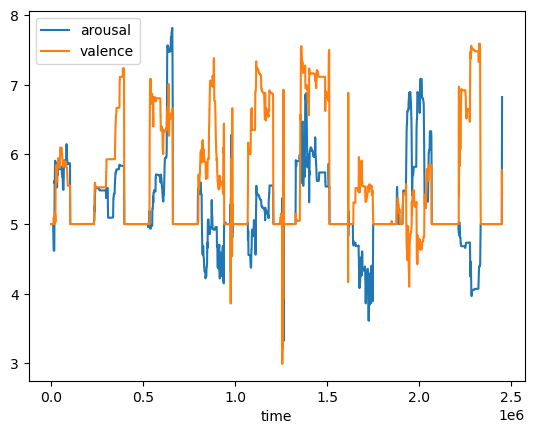

In [3]:
df1.plot(x="time", y=["arousal","valence"])
plt.show()

Leemos el csv de las variables Fisiológicas, y las representamos.

In [4]:
df2=pd.read_csv('Bruto/sub_18_physiological.csv')
df2=df2.rename(columns={"daqtime": "time"})
length_orig_df2=len(df2)
print(df2)

            time    ecg     bvp     gsr     rsp     skt  emg_zygo  emg_coru  \
0              0  1.171  37.735  24.207  37.580  27.836     6.302     7.494   
1              1  1.171  37.852  24.270  37.590  27.829     6.343     7.494   
2              2  1.171  37.968  24.333  37.599  27.822     6.384     7.494   
3              3  1.149  38.065  24.357  37.580  27.812     6.263     7.371   
4              4  1.135  38.085  24.361  37.628  27.822     6.343     7.573   
...          ...    ...     ...     ...     ...     ...       ...       ...   
2451579  2451579  1.313  35.217  18.495  41.268  34.266    16.532    13.040   
2451580  2451580  1.293  35.362  18.495  41.268  34.266    16.325    12.916   
2451581  2451581  1.286  35.373  18.542  41.249  34.249    15.917    12.711   
2451582  2451582  1.267  35.344  18.538  41.258  34.266    15.790    12.587   
2451583  2451583  1.247  35.498  18.562  41.258  34.262    15.464    12.383   

         emg_trap  video  
0           7.534     10

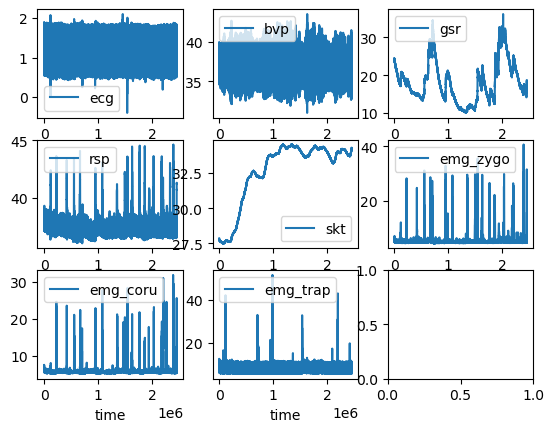

In [5]:
#define subplot layout
fig, axes = plt.subplots(nrows=3, ncols=3)

#add DataFrames to subplots
df2.plot(ax=axes[0,0],x="time",y="ecg")
df2.plot(ax=axes[0,1],x="time",y="bvp")
df2.plot(ax=axes[0,2],x="time",y="gsr")
df2.plot(ax=axes[1,0],x="time",y="rsp")
df2.plot(ax=axes[1,1],x="time",y="skt")
df2.plot(ax=axes[1,2],x="time",y="emg_zygo")
df2.plot(ax=axes[2,0],x="time",y="emg_coru")
df2.plot(ax=axes[2,1],x="time",y="emg_trap")
plt.show()

<AxesSubplot:xlabel='time'>

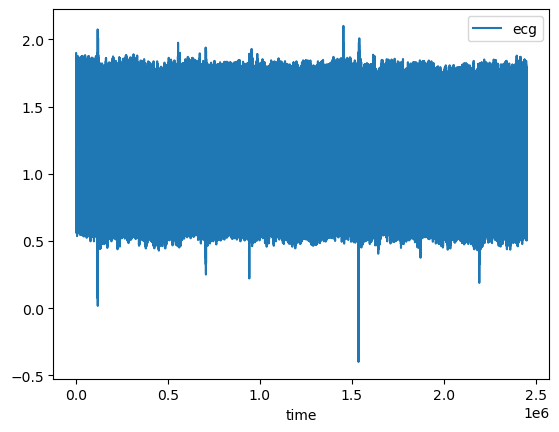

In [6]:
df2.plot(x="time",y="ecg")

<AxesSubplot:xlabel='time'>

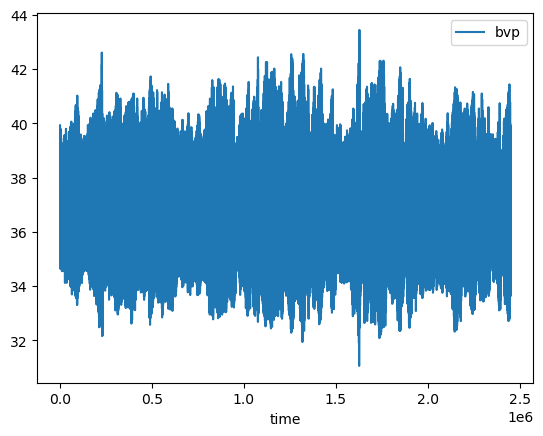

In [7]:
df2.plot(x="time",y="bvp")

<AxesSubplot:xlabel='time'>

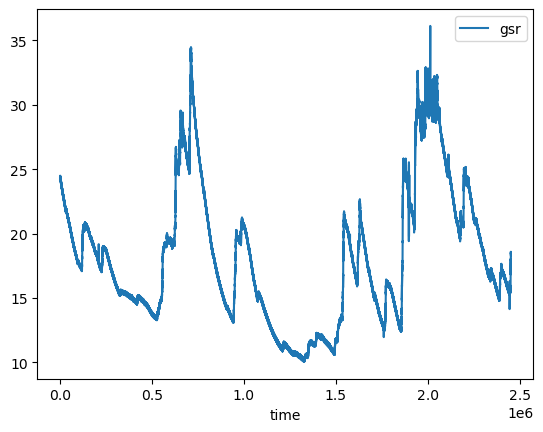

In [8]:
df2.plot(x="time",y="gsr")

<AxesSubplot:xlabel='time'>

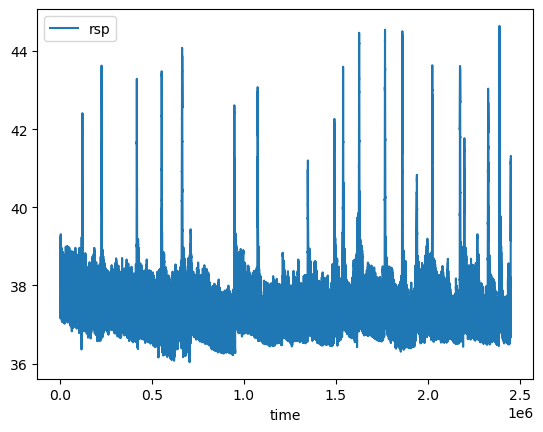

In [9]:
df2.plot(x="time",y="rsp")

<AxesSubplot:xlabel='time'>

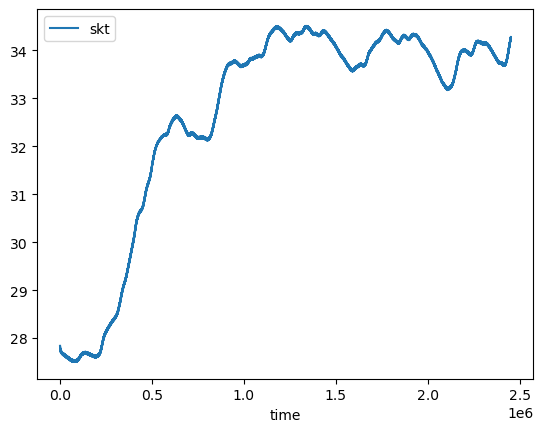

In [10]:
df2.plot(x="time",y="skt")


<AxesSubplot:xlabel='time'>

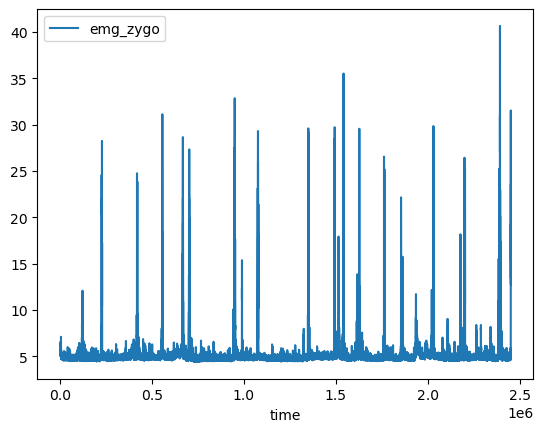

In [11]:
df2.plot(x="time",y="emg_zygo")


<AxesSubplot:xlabel='time'>

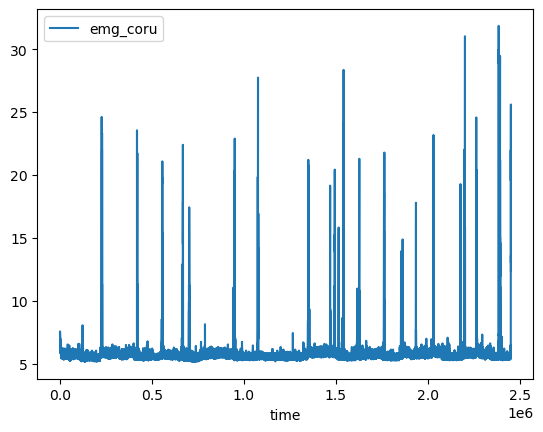

In [12]:
df2.plot(x="time",y="emg_coru")

<AxesSubplot:xlabel='time'>

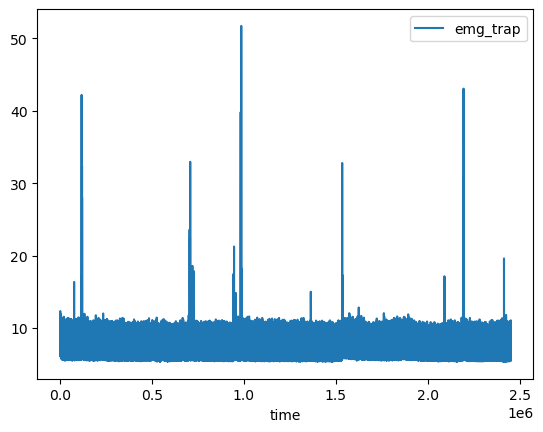

In [13]:
df2.plot(x="time",y="emg_trap")

El paper más completo que trata esto es CorrNet, donde se hace:

"Since the sampling rates of V-A and signals are 20 and 1000 Hz
respectively, we down-sampled all the signals to 50 Hz by decimation down-sampling. The EDA signals were
first filtered using a low pass filter with a 2 Hz cutoff frequency to remove noise.
For the BVP signal, we pre-processed it with a four-order butterworth bandpass filter with
cutoff frequencies [30, 200] Hz to eliminate the bursts. An elliptic band-pass filter
with cutoff frequencies [0.005, 0.1] was used to filter the ST signal. We followed the
standard filtering procedure widely used in previous works to pre-process the
physiological signals. Then the filtered signals are segmented into 2-second (sample size:
100 for CASE) instances."

O sea:

A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

D) Se normalizan las señales a 0 - 1, segun Min - Max.

E) Se busca la frecuencia en común de ambos a 50 Hz. Se hizo un estudio y fue la solución de compromiso.

F) Se utilizan ventanas de 2 segundos.

Lo vamos haciendo poco a poco.

    A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

<AxesSubplot:>

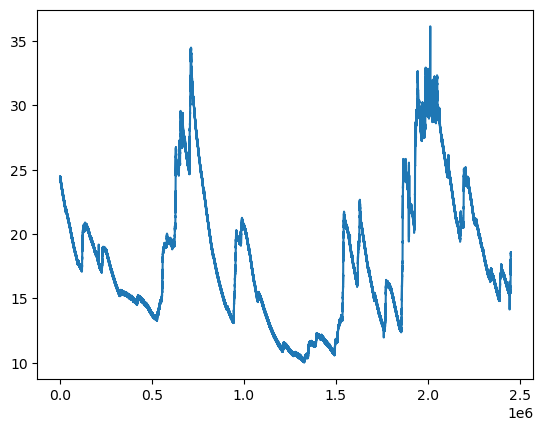

In [14]:
gsr_signal_notfiltered=df2['gsr']
gsr_signal_notfiltered.plot()

Representamos la senal en el dominio de la frecuencia. Vemos que hay frecuencias hasta el 500. Las querremos quitar todas menos las menores a 2 Hz. 

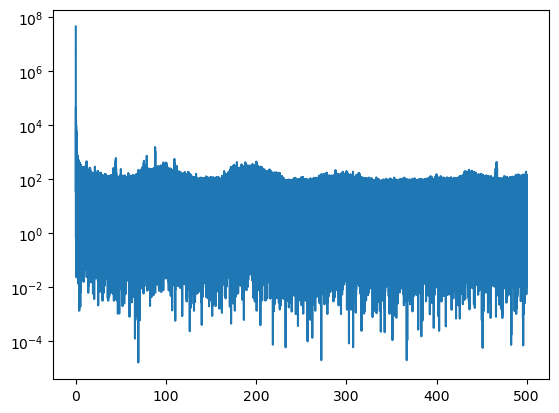

In [15]:
yf = rfft(gsr_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

In [16]:
lowpassfilter=signal.butter(N=10, Wn=2, btype='lp', fs=1000, output='sos')
gsr_filtered = signal.sosfilt(lowpassfilter, gsr_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias a partir de los 2 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente las frecuencias mayores a 2 Hz. 

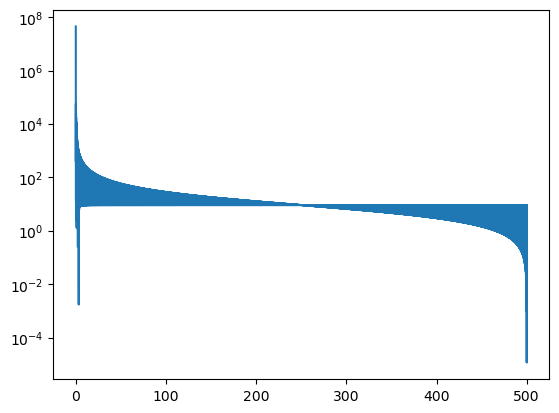

In [17]:
yf = rfft(gsr_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

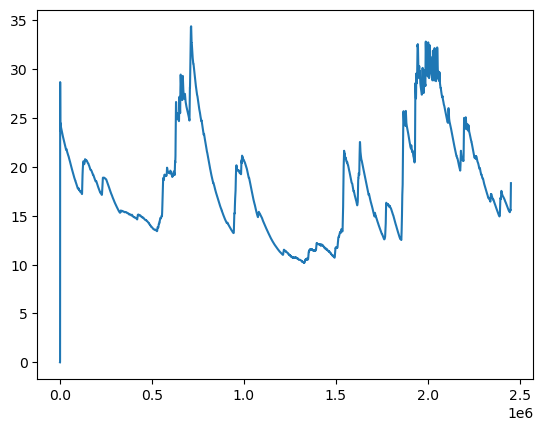

In [18]:
plt.plot(gsr_filtered)

In [19]:
gsr_signal_filtered = pd.DataFrame(gsr_filtered)
gsr_signal_filtered=gsr_signal_filtered.round(3)
gsr_signal_filtered=gsr_signal_filtered.rename(columns={0: "gsr"})
gsr_signal_filtered

gsr
0         0.000
1         0.000
2         0.000
3         0.000
4         0.000
...         ...
2451579  18.333
2451580  18.334
2451581  18.334
2451582  18.335
2451583  18.335

[2451584 rows x 1 columns]

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

<AxesSubplot:>

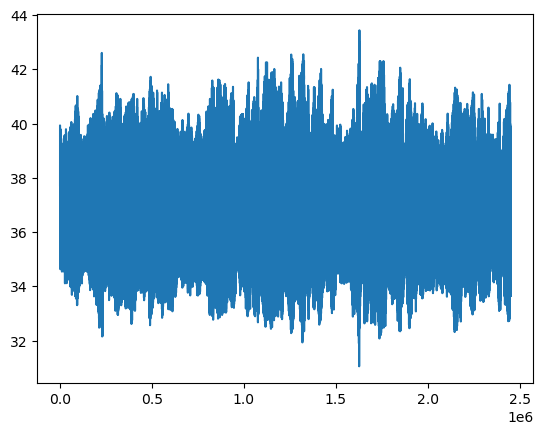

In [20]:
bvp_signal_notfiltered=df2['bvp']
bvp_signal_notfiltered.plot()

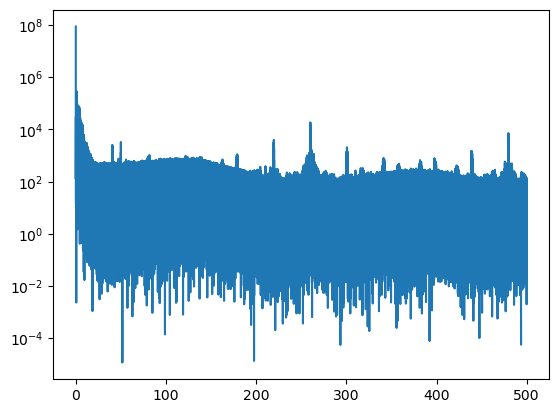

In [21]:
yf = rfft(bvp_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos el filtro Butter con frecuencias de corte de 30 a 200 Hz, de cuarto orden. Es un filtro paso banda.

In [22]:
butterfilter=signal.butter(N=4, Wn=[30,200], btype='bandpass', fs=1000, output='sos')
bvp_filtered = signal.sosfilt(butterfilter, bvp_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias menores de 30 Hz y mayores a 200 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente esas frecuencias.

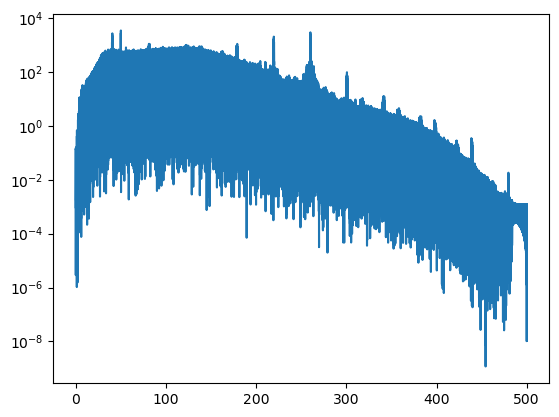

In [23]:
yf = rfft(bvp_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

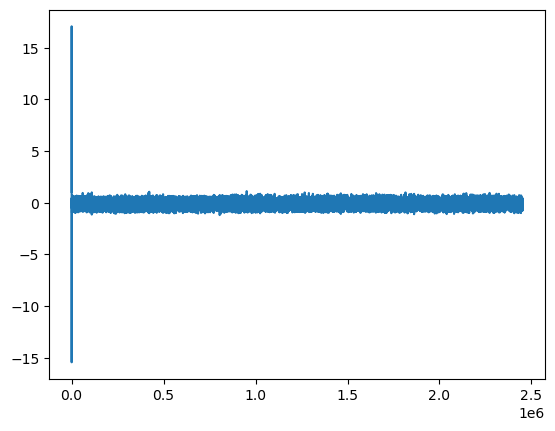

In [24]:
plt.plot(bvp_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [25]:
bvp_signal_filtered = pd.DataFrame(bvp_filtered)
bvp_signal_filtered=bvp_signal_filtered.round(3)
bvp_signal_filtered=bvp_signal_filtered.rename(columns={0: "bvp"})
bvp_signal_filtered=bvp_signal_filtered.add(37)
bvp_signal_filtered

bvp
0        38.049
1        42.853
2        50.784
3        54.080
4        46.629
...         ...
2451579  37.014
2451580  36.991
2451581  36.973
2451582  36.986
2451583  36.998

[2451584 rows x 1 columns]

    C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

<AxesSubplot:>

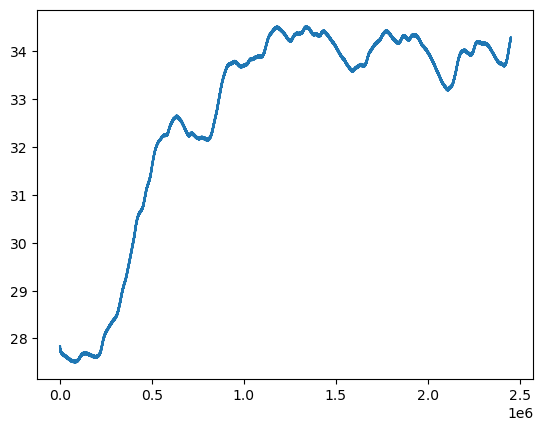

In [26]:
skt_signal_notfiltered=df2['skt']
skt_signal_notfiltered.plot()

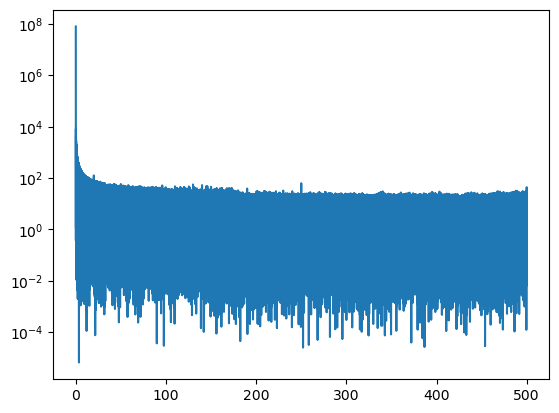

In [27]:
yf = rfft(skt_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos nuestro filtro eliptico con frecuencias corte [0.005, 0.1] a señal skt.

In [28]:
ellipticfilter=signal.ellip(N=4,rp=1, rs=1, Wn=[0.005,0.1], btype='bandpass', fs=1000, output='sos')
skt_filtered = signal.sosfilt(ellipticfilter, skt_signal_notfiltered)

Comprobamos la senal filtrada. Algo ha filtrado.

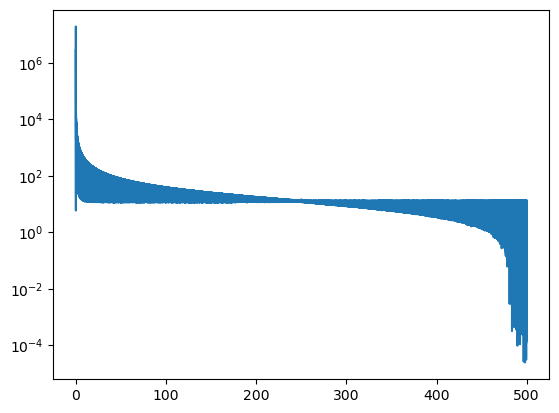

In [29]:
yf = rfft(skt_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

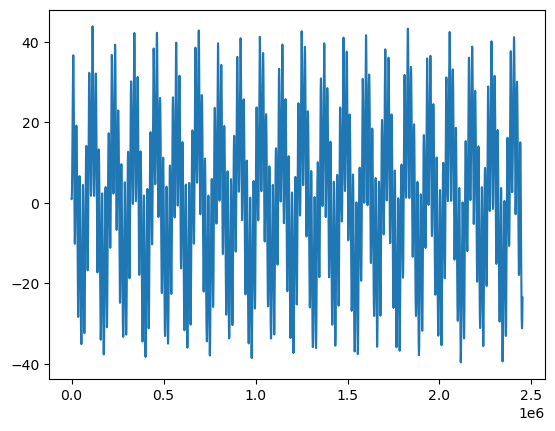

In [30]:
plt.plot(skt_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [31]:
skt_signal_filtered = pd.DataFrame(skt_filtered)
skt_signal_filtered=skt_signal_filtered.round(3)
skt_signal_filtered=skt_signal_filtered.rename(columns={0: "skt"})
skt_signal_filtered=skt_signal_filtered.add(40)
skt_signal_filtered

skt
0        40.892
1        40.892
2        40.892
3        40.891
4        40.892
...         ...
2451579  16.469
2451580  16.473
2451581  16.477
2451582  16.482
2451583  16.487

[2451584 rows x 1 columns]

D) Se normalizan las senales.

Antes de normalizarlas, vamos a borrar las primeras 5000, ya que por los filtrados los principios de las senales son un poco raros. Borramos las columnas que acabamos de tunear del dataframe con todo.

In [32]:
df2=df2.drop(columns=["skt","bvp","gsr"])
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video
0              0  1.171  37.580     6.302     7.494     7.534     10
1              1  1.171  37.590     6.343     7.494     7.534     10
2              2  1.171  37.599     6.384     7.494     7.534     10
3              3  1.149  37.580     6.263     7.371     7.453     10
4              4  1.135  37.628     6.343     7.573     7.696     10
...          ...    ...     ...       ...       ...       ...    ...
2451579  2451579  1.313  41.268    16.532    13.040     6.099     12
2451580  2451580  1.293  41.268    16.325    12.916     6.138     12
2451581  2451581  1.286  41.249    15.917    12.711     6.057     12
2451582  2451582  1.267  41.258    15.790    12.587     6.056     12
2451583  2451583  1.247  41.258    15.464    12.383     6.097     12

[2451584 rows x 7 columns]

In [33]:
df2=pd.concat([df2, bvp_signal_filtered, gsr_signal_filtered,skt_signal_filtered], axis=1)
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video     bvp  \
0              0  1.171  37.580     6.302     7.494     7.534     10  38.049   
1              1  1.171  37.590     6.343     7.494     7.534     10  42.853   
2              2  1.171  37.599     6.384     7.494     7.534     10  50.784   
3              3  1.149  37.580     6.263     7.371     7.453     10  54.080   
4              4  1.135  37.628     6.343     7.573     7.696     10  46.629   
...          ...    ...     ...       ...       ...       ...    ...     ...   
2451579  2451579  1.313  41.268    16.532    13.040     6.099     12  37.014   
2451580  2451580  1.293  41.268    16.325    12.916     6.138     12  36.991   
2451581  2451581  1.286  41.249    15.917    12.711     6.057     12  36.973   
2451582  2451582  1.267  41.258    15.790    12.587     6.056     12  36.986   
2451583  2451583  1.247  41.258    15.464    12.383     6.097     12  36.998   

            gsr     skt  
0         0.000  40.892  
1         0.000  40.892  
2         0.000  40.892  
3         0.000  40.891  
4         0.000  40.892  
...         ...     ...  
2451579  18.333  16.469  
2451580  18.334  16.473  
2451581  18.334  16.477  
2451582  18.335  16.482  
2451583  18.335  16.487  

[2451584 rows x 10 columns]

Tras aclarar esto, ya pasamos a normalizar. Antes, quitamos los videos que van al train, para que se normalicen solo los datos que van a ser entrenados realmente (sin los videos de BlueScreen, EndVid y StartVid).

In [34]:
df2 = df2[df2.video != 10]
df2 = df2[df2.video != 11]
df2 = df2[df2.video != 12]
scaler = MinMaxScaler()
scaler.fit(df2)
normalized = pd.DataFrame(scaler.transform(df2), index=df2.index, columns=df2.columns)
df2_normalized = pd.DataFrame(normalized, columns=df2.columns)
df2_normalized=df2_normalized.drop(columns=["video","time"])
numvideo_bien = df2["video"] 
tiempo_bien=df2["time"] 
df2_normalized=df2_normalized.join(numvideo_bien)
df2_normalized=df2_normalized.join(tiempo_bien)
df2=df2_normalized[["time","ecg","bvp","gsr","skt","rsp","emg_zygo","emg_coru","emg_trap","video"]]
df2

time       ecg       bvp       gsr       skt       rsp  emg_zygo  \
221501    221501  0.391736  0.537424  0.316596  0.787383  0.317125  0.016886   
221502    221502  0.395397  0.553231  0.316596  0.787308  0.317125  0.019887   
221503    221503  0.393305  0.566713  0.316596  0.787221  0.315936  0.019925   
221504    221504  0.393305  0.567643  0.316596  0.787158  0.317125  0.018424   
221505    221505  0.398536  0.540679  0.316596  0.787071  0.313425  0.013809   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.278243  0.577871  0.293323  0.354296  0.388742  0.015310   
2331580  2331580  0.279812  0.593212  0.293323  0.354383  0.388742  0.013771   
2331581  2331581  0.281904  0.577406  0.293279  0.354458  0.396406  0.018349   
2331582  2331582  0.281904  0.559275  0.293279  0.354545  0.390196  0.013809   
2331583  2331583  0.276674  0.575546  0.293279  0.354620  0.390063  0.019887   

         emg_coru  emg_trap  video  
221501   0.025283  0.032618      2  
221502   0.025321  0.033704      2  
221503   0.023734  0.034791      2  
221504   0.026870  0.032644      2  
221505   0.020598  0.031532      2  
...           ...       ...    ...  
2331579  0.020520  0.015183      5  
2331580  0.018972  0.017356      5  
2331581  0.017384  0.017382      5  
2331582  0.018933  0.019528      5  
2331583  0.018972  0.018468      5  

[1270083 rows x 10 columns]

    E) Frecuencia común 50 Hz

Para la frecuencia comun a ambos, ello implica tener lecturas cada 1/50 = 20 ms. Para las senales fisiologicas lo tenemos, pero para las annotations no, por lo que hay que resample. Primero resampleamos a que nos saque todos los valores por milisegundo de annotations, y luego downsampleamos para quedarnos solo con los que sean menores a 20 ms. 

In [35]:
n_samples=length_orig_df2
df1_clean=df1.drop(columns=['time', 'video'])
array1_resampled=signal.resample(df1_clean, n_samples)
df1_resampled=pd.DataFrame(array1_resampled,columns=["valence","arousal"])
df1_resampled=df1_resampled.round(3)
print(df1_resampled)

         valence  arousal
0          5.000    5.000
1          4.994    4.975
2          4.988    4.951
3          4.982    4.929
4          4.976    4.907
...          ...      ...
2451579    5.036    5.143
2451580    5.029    5.112
2451581    5.021    5.082
2451582    5.014    5.054
2451583    5.007    5.026

[2451584 rows x 2 columns]


Unimos los csv, con columna intersección en "time". Borramos los instantes de tiempo X e Y porque en realidad no son necesarios. Reordenamos las columnas.

In [36]:
df3=pd.merge(df1_resampled, df2, left_index=True, right_index=True)

columnsTitles = ['time', 'ecg', 'bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap','valence','arousal','video']
df3 = df3.reindex(columns=columnsTitles)

print(df3)

            time       ecg       bvp       gsr       rsp       skt  emg_zygo  \
221501    221501  0.391736  0.537424  0.316596  0.317125  0.787383  0.016886   
221502    221502  0.395397  0.553231  0.316596  0.317125  0.787308  0.019887   
221503    221503  0.393305  0.566713  0.316596  0.315936  0.787221  0.019925   
221504    221504  0.393305  0.567643  0.316596  0.317125  0.787158  0.018424   
221505    221505  0.398536  0.540679  0.316596  0.313425  0.787071  0.013809   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.278243  0.577871  0.293323  0.388742  0.354296  0.015310   
2331580  2331580  0.279812  0.593212  0.293323  0.388742  0.354383  0.013771   
2331581  2331581  0.281904  0.577406  0.293279  0.396406  0.354458  0.018349   
2331582  2331582  0.281904  0.559275  0.293279  0.390196  0.354545  0.013809   
2331583  2331583  0.276674  0.575546  0.293279  0.390063  0.354620  0.019887   

         emg_coru  emg_trap  valence  a

Downsampleamos a 20 ms y eliminamos la columna tiempo. 

In [37]:
df3 = df3.drop(df3[df3.time%20 != 0].index)
df3 = df3.drop(columns=['time'])
print(df3)

              ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
221520   0.419456  0.544863  0.316596  0.313293  0.785937  0.018349  0.022108   
221540   0.469142  0.573687  0.316552  0.313293  0.784416  0.016848  0.017346   
221560   0.541318  0.573222  0.316552  0.308272  0.782896  0.016886  0.022108   
221580   0.584205  0.582055  0.316552  0.308272  0.781363  0.018424  0.020559   
221600   0.568515  0.537889  0.316552  0.305761  0.779842  0.019962  0.018972   
...           ...       ...       ...       ...       ...       ...       ...   
2331500  0.288703  0.560669  0.293455  0.404070  0.347803  0.018349  0.020520   
2331520  0.283473  0.637843  0.293411  0.395217  0.349448  0.013771  0.017346   
2331540  0.269874  0.529986  0.293367  0.396538  0.351093  0.019962  0.023734   
2331560  0.273013  0.585774  0.293323  0.393895  0.352738  0.015347  0.017384   
2331580  0.279812  0.593212  0.293323  0.388742  0.354383  0.013771  0.018972   

         emg_trap  valence 

Creamos la ventana de n = 2 segundos. Una ventana de datos simplemente será concatenar los datos dentro de grupos de 2 segundos, haciendo la media de valencia y de arousal de todos ellos. 

Como la frecuencia de muestreo son 20 ms, cada ventana de 2 segundos tendrá en total 100 observaciones. Después, esto lo "flattenaremos" para que el modelo ML en R pueda tragarlo.  

En primer lugar, como las ventanas son de 2 segundos, eliminamos un número de datos para que nos den las ventanas justas. Tendríamos varios criterios:

- A) Ver en el completo de los datos las entradas que tenemos múltiplos de 100 (ventanas de 2 s), y eliminar del múltiplo más alto hasta el final.

- B) Algo más fino quizá sería hacer lo mismo pero video a video. 

Por simplicidad y ver lo que sale hacemos A). Comenzamos creando un nuevo indice desde 0 del Dataframe que tenemos y borramos el valor del video. 

In [38]:
df3 = df3.drop(columns=['video'])
df3 = df3.reset_index()
df3 = df3.drop(columns=['index'])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.419456  0.544863  0.316596  0.313293  0.785937  0.018349  0.022108   
1      0.469142  0.573687  0.316552  0.313293  0.784416  0.016848  0.017346   
2      0.541318  0.573222  0.316552  0.308272  0.782896  0.016886  0.022108   
3      0.584205  0.582055  0.316552  0.308272  0.781363  0.018424  0.020559   
4      0.568515  0.537889  0.316552  0.305761  0.779842  0.019962  0.018972   
...         ...       ...       ...       ...       ...       ...       ...   
63499  0.288703  0.560669  0.293455  0.404070  0.347803  0.018349  0.020520   
63500  0.283473  0.637843  0.293411  0.395217  0.349448  0.013771  0.017346   
63501  0.269874  0.529986  0.293367  0.396538  0.351093  0.019962  0.023734   
63502  0.273013  0.585774  0.293323  0.393895  0.352738  0.015347  0.017384   
63503  0.279812  0.593212  0.293323  0.388742  0.354383  0.013771  0.018972   

       emg_trap  valence  arousal  
0      0.027186    5.000    5.000  
1      0.024987    5.000    5.000  
2      0.023953    5.000    5.000  
3      0.021754    5.000    5.000  
4      0.023927    5.000    5.000  
...         ...      ...      ...  
63499  0.014123    7.536    4.416  
63500  0.013010    7.533    4.417  
63501  0.015236    7.530    4.418  
63502  0.016296    7.528    4.420  
63503  0.017356    7.527    4.423  

[63504 rows x 10 columns]

Como tenemos 63504 filas, necesitamos borrar solo las ultimas 4.

In [39]:
df3=df3.drop([63503, 63502, 63501, 63500])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.419456  0.544863  0.316596  0.313293  0.785937  0.018349  0.022108   
1      0.469142  0.573687  0.316552  0.313293  0.784416  0.016848  0.017346   
2      0.541318  0.573222  0.316552  0.308272  0.782896  0.016886  0.022108   
3      0.584205  0.582055  0.316552  0.308272  0.781363  0.018424  0.020559   
4      0.568515  0.537889  0.316552  0.305761  0.779842  0.019962  0.018972   
...         ...       ...       ...       ...       ...       ...       ...   
63495  0.287134  0.586239  0.293588  0.413187  0.341197  0.012270  0.015797   
63496  0.295502  0.596932  0.293588  0.413055  0.342855  0.018349  0.020520   
63497  0.295502  0.544398  0.293544  0.415566  0.344513  0.013771  0.018933   
63498  0.297071  0.600186  0.293499  0.409223  0.346158  0.019850  0.023656   
63499  0.288703  0.560669  0.293455  0.404070  0.347803  0.018349  0.020520   

       emg_trap  valence  arousal  
0      0.027186    5.000    5.000  
1      0.024987    5.000    5.000  
2      0.023953    5.000    5.000  
3      0.021754    5.000    5.000  
4      0.023927    5.000    5.000  
...         ...      ...      ...  
63495  0.015209    7.548    4.407  
63496  0.017356    7.545    4.410  
63497  0.014096    7.542    4.412  
63498  0.015183    7.539    4.415  
63499  0.014123    7.536    4.416  

[63500 rows x 10 columns]

Y ahora si, con split dividimos el Dataset en 635 entradas de 100 datos cada una. 

In [40]:
df3_split_2s = np.array_split(df3, len(df3)/25)
df3_split_2s

[         ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
 0   0.419456  0.544863  0.316596  0.313293  0.785937  0.018349  0.022108   
 1   0.469142  0.573687  0.316552  0.313293  0.784416  0.016848  0.017346   
 2   0.541318  0.573222  0.316552  0.308272  0.782896  0.016886  0.022108   
 3   0.584205  0.582055  0.316552  0.308272  0.781363  0.018424  0.020559   
 4   0.568515  0.537889  0.316552  0.305761  0.779842  0.019962  0.018972   
 5   0.427824  0.580195  0.316508  0.305761  0.778310  0.023039  0.025321   
 6   0.311192  0.596932  0.316508  0.305629  0.776789  0.024503  0.031594   
 7   0.269874  0.508601  0.316464  0.301797  0.775244  0.022964  0.028496   
 8   0.251046  0.565318  0.316464  0.296776  0.773711  0.019925  0.028496   
 9   0.247385  0.509995  0.316419  0.292944  0.772165  0.015347  0.025321   
 10  0.255753  0.557415  0.316419  0.294133  0.770632  0.018386  0.028457   
 11  0.255753  0.592283  0.316375  0.291623  0.769087  0.018349  0.028535   

Ahora, realizaremos el Flatteneado. Las matrices las haremos una linea continua: pasamos de tener 100 observaciones de 8 variables a tener 1 observacion de 800 variables. 
Creamos el Dataframe que nos contenga todo, que tendrá 800 variables + Valence + Arousal (802 en total). Le ponemos nombre a las columnas del Dataframe solamente porque no se puede crear un Dataframe sin columnas, sino solo nos importaría llamar a la de Valence y Arousal.  

In [41]:
list_array = list(np.arange(1,201))
list_array.append("valence")
list_array.append("arousal")
df4 = pd.DataFrame(columns=list_array)
df4

Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]
Index: []

[0 rows x 202 columns]

Y ahora hago el proceso de hacer el flatenning, y obtener el nuevo Dataframe con la ventana aplicada que exportaremos. Lo hacemos con un for para que repase todas las agrupaciones de 8 x 100 datos. De cada ventana calculamos (según papers) la valence y arousal promedios, y eso lo anadiremos en las ultimas dos columnas). 

In [42]:
for entrada in df3_split_2s:
    ave_valence=entrada['valence'].mean()
    ave_arousal=entrada['arousal'].mean()
    entrada=entrada.drop(columns=['valence','arousal'])
    a=entrada.to_numpy().flatten()
    a=np.append(a, ave_valence)
    a=np.append(a, ave_arousal)
    df4.loc[len(df4)] = a

In [43]:
df4

1         2         3         4         5         6         7  \
0     0.419456  0.544863  0.316596  0.313293  0.785937  0.018349  0.022108   
1     0.247385  0.541144  0.316110  0.262156  0.747377  0.010694  0.022147   
2     0.263075  0.553696  0.315315  0.158562  0.708604  0.029156  0.025321   
3     0.583159  0.567178  0.314388  0.084434  0.670904  0.026154  0.028535   
4     0.271444  0.581125  0.313372  0.204678  0.635410  0.015310  0.022108   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.261506  0.572757  0.292660  0.739165  0.164747  0.015272  0.031671   
2536  0.293933  0.589958  0.292307  0.668869  0.194621  0.015272  0.020520   
2537  0.288703  0.504881  0.292704  0.640724  0.229243  0.015310  0.017423   
2538  0.300732  0.602510  0.293720  0.569239  0.267529  0.016886  0.022108   
2539  0.264644  0.544398  0.294206  0.491015  0.308121  0.012233  0.026870   

             8         9        10  ...       193       194       195  \
0     0.027186  0.469142  0.573687  ...  0.255753  0.585774  0.316154   
1     0.015236  0.278243  0.520223  ...  0.275105  0.579265  0.315359   
2     0.018468  0.264644  0.564389  ...  0.623431  0.565318  0.314432   
3     0.036963  0.293410  0.532775  ...  0.268305  0.563924  0.313461   
4     0.014096  0.269874  0.564389  ...  0.518828  0.567178  0.312356   
...        ...       ...       ...  ...       ...       ...       ...   
2535  0.019528  0.271444  0.624826  ...  0.302301  0.553231  0.292307   
2536  0.018468  0.293933  0.496978  ...  0.287134  0.600651  0.292704   
2537  0.017382  0.442992  0.529056  ...  0.305962  0.634124  0.293676   
2538  0.019555  0.295502  0.597861  ...  0.838389  0.563459  0.294206   
2539  0.055405  0.405335  0.596467  ...  0.288703  0.560669  0.293455   

           196       197       198       199       200  valence  arousal  
0     0.262156  0.748934  0.010694  0.023695  0.018495  5.00000   5.0000  
1     0.165037  0.710137  0.024540  0.028496  0.025013  5.00000   5.0000  
2     0.083113  0.672375  0.021501  0.025321  0.015209  5.00000   5.0000  
3     0.199524  0.636768  0.016886  0.022108  0.015183  5.00000   5.0000  
4     0.350423  0.604240  0.024540  0.025283  0.030392  5.00000   5.0000  
...        ...       ...       ...       ...       ...      ...      ...  
2535  0.671512  0.193337  0.018349  0.022108  0.021728  7.58900   4.3940  
2536  0.640724  0.227785  0.012195  0.017307  0.015183  7.58900   4.3940  
2537  0.571749  0.265934  0.012270  0.018972  0.017382  7.58900   4.3940  
2538  0.491147  0.306463  0.013734  0.023695  0.017382  7.58640   4.3940  
2539  0.404070  0.347803  0.018349  0.020520  0.014123  7.55828   4.3996  

[2540 rows x 202 columns]

Para esta iteracion, analizamos los datos segun CorrNet. CorrNet propone 3 clasificaciones diferentes:
- Clasificación en 2 clases:
    
    Modelo ML A: Clasificamos Arousal en High y Low.
    
    Modelo ML B: Clasificamos Valence en High y Low. 


- Clasificación en 3 clases:
    
    Modelo ML C: Clasificamos Arousal en High, Neutral y Low.
   
    Modelo ML D: Clasificamos Valence en High, Neutral y Low.
    
    
- Clasificación en 4 clases:
    
    Modelo ML E: Clasificamos Valence y Arousal en los cuatro cuadrantes: High High, High Low, Low Low y Low High. 
   
   
Para cada uno, realizamos un dataframe diferente. 

- Modelo A. Clasificamos Arousal en High y Low. High --> 2 y Low --> 1

In [44]:
df4_A = df4.drop(columns=['valence'])
df4_A=df4_A.rename(columns={"arousal": "auxiliar"})
df4_A.loc[df4_A['auxiliar'] < 5, 'arousal'] = 1
df4_A.loc[df4_A['auxiliar'] >= 5, 'arousal'] = 2
df4_A = df4_A.drop(columns=['auxiliar'])
print(df4_A)

             1         2         3         4         5         6         7  \
0     0.419456  0.544863  0.316596  0.313293  0.785937  0.018349  0.022108   
1     0.247385  0.541144  0.316110  0.262156  0.747377  0.010694  0.022147   
2     0.263075  0.553696  0.315315  0.158562  0.708604  0.029156  0.025321   
3     0.583159  0.567178  0.314388  0.084434  0.670904  0.026154  0.028535   
4     0.271444  0.581125  0.313372  0.204678  0.635410  0.015310  0.022108   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.261506  0.572757  0.292660  0.739165  0.164747  0.015272  0.031671   
2536  0.293933  0.589958  0.292307  0.668869  0.194621  0.015272  0.020520   
2537  0.288703  0.504881  0.292704  0.640724  0.229243  0.015310  0.017423   
2538  0.300732  0.602510  0.293720  0.569239  0.267529  0.016886  0.022108   
2539  0.264644  0.544398  0.294206  0.491015  0.308121  0.012233  0.026870   

             8         9        10  ...       192       193    

In [45]:
df4_A.to_csv('Output/arousal_2_clases_sub18.csv', index=False)

- Modelo B. Clasificamos Valence en High y Low. High --> 2 y Low --> 1

In [46]:
df4_B = df4.drop(columns=['arousal'])
df4_B=df4_B.rename(columns={"valence": "auxiliar"})
df4_B.loc[df4_B['auxiliar'] < 5, 'valence'] = 1
df4_B.loc[df4_B['auxiliar'] >= 5, 'valence'] = 2
df4_B = df4_B.drop(columns=['auxiliar'])
print(df4_B)

             1         2         3         4         5         6         7  \
0     0.419456  0.544863  0.316596  0.313293  0.785937  0.018349  0.022108   
1     0.247385  0.541144  0.316110  0.262156  0.747377  0.010694  0.022147   
2     0.263075  0.553696  0.315315  0.158562  0.708604  0.029156  0.025321   
3     0.583159  0.567178  0.314388  0.084434  0.670904  0.026154  0.028535   
4     0.271444  0.581125  0.313372  0.204678  0.635410  0.015310  0.022108   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.261506  0.572757  0.292660  0.739165  0.164747  0.015272  0.031671   
2536  0.293933  0.589958  0.292307  0.668869  0.194621  0.015272  0.020520   
2537  0.288703  0.504881  0.292704  0.640724  0.229243  0.015310  0.017423   
2538  0.300732  0.602510  0.293720  0.569239  0.267529  0.016886  0.022108   
2539  0.264644  0.544398  0.294206  0.491015  0.308121  0.012233  0.026870   

             8         9        10  ...       192       193    

In [47]:
df4_B.to_csv('Output/valence_2_clases_sub18.csv', index=False)

- Modelo C. Clasificamos Arousal en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [48]:
df4_C = df4.drop(columns=['valence'])
df4_C=df4_C.rename(columns={"arousal": "auxiliar"})
df4_C.loc[df4_C['auxiliar'] < 3, 'arousal'] = 1
df4_C.loc[(df4_C['auxiliar'] >= 3) & (df4_C['auxiliar'] < 6), 'arousal'] = 2
df4_C.loc[(df4_C['auxiliar'] >= 6), 'arousal'] = 3
df4_C = df4_C.drop(columns=['auxiliar'])
print(df4_C)

             1         2         3         4         5         6         7  \
0     0.419456  0.544863  0.316596  0.313293  0.785937  0.018349  0.022108   
1     0.247385  0.541144  0.316110  0.262156  0.747377  0.010694  0.022147   
2     0.263075  0.553696  0.315315  0.158562  0.708604  0.029156  0.025321   
3     0.583159  0.567178  0.314388  0.084434  0.670904  0.026154  0.028535   
4     0.271444  0.581125  0.313372  0.204678  0.635410  0.015310  0.022108   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.261506  0.572757  0.292660  0.739165  0.164747  0.015272  0.031671   
2536  0.293933  0.589958  0.292307  0.668869  0.194621  0.015272  0.020520   
2537  0.288703  0.504881  0.292704  0.640724  0.229243  0.015310  0.017423   
2538  0.300732  0.602510  0.293720  0.569239  0.267529  0.016886  0.022108   
2539  0.264644  0.544398  0.294206  0.491015  0.308121  0.012233  0.026870   

             8         9        10  ...       192       193    

In [49]:
df4_C.to_csv('Output/arousal_3_clases_sub18.csv', index=False)

- Modelo D. Clasificamos Valence en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [50]:
df4_D = df4.drop(columns=['arousal'])
df4_D=df4_D.rename(columns={"valence": "auxiliar"})
df4_D.loc[df4_D['auxiliar'] < 3, 'valence'] = 1
df4_D.loc[(df4_D['auxiliar'] >= 3) & (df4_D['auxiliar'] < 6), 'valence'] = 2
df4_D.loc[(df4_D['auxiliar'] >= 6), 'valence'] = 3
df4_D = df4_D.drop(columns=['auxiliar'])
print(df4_D)

             1         2         3         4         5         6         7  \
0     0.419456  0.544863  0.316596  0.313293  0.785937  0.018349  0.022108   
1     0.247385  0.541144  0.316110  0.262156  0.747377  0.010694  0.022147   
2     0.263075  0.553696  0.315315  0.158562  0.708604  0.029156  0.025321   
3     0.583159  0.567178  0.314388  0.084434  0.670904  0.026154  0.028535   
4     0.271444  0.581125  0.313372  0.204678  0.635410  0.015310  0.022108   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.261506  0.572757  0.292660  0.739165  0.164747  0.015272  0.031671   
2536  0.293933  0.589958  0.292307  0.668869  0.194621  0.015272  0.020520   
2537  0.288703  0.504881  0.292704  0.640724  0.229243  0.015310  0.017423   
2538  0.300732  0.602510  0.293720  0.569239  0.267529  0.016886  0.022108   
2539  0.264644  0.544398  0.294206  0.491015  0.308121  0.012233  0.026870   

             8         9        10  ...       192       193    

In [51]:
df4_D.to_csv('Output/valence_3_clases_sub18.csv', index=False)

- Modelo E. Clasificamos Valence y Arousal. Valence High y Arousal High --> 4, Valence High y Arousal Low --> 3, Valence Low y Arousal High --> 2, Valence Low y Arousal Low --> 1. 

In [52]:
df4_E = df4
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 1
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 2
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 3
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 4
df4_E = df4_E.drop(columns=['valence', 'arousal'])
print(df4_E)

             1         2         3         4         5         6         7  \
0     0.419456  0.544863  0.316596  0.313293  0.785937  0.018349  0.022108   
1     0.247385  0.541144  0.316110  0.262156  0.747377  0.010694  0.022147   
2     0.263075  0.553696  0.315315  0.158562  0.708604  0.029156  0.025321   
3     0.583159  0.567178  0.314388  0.084434  0.670904  0.026154  0.028535   
4     0.271444  0.581125  0.313372  0.204678  0.635410  0.015310  0.022108   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.261506  0.572757  0.292660  0.739165  0.164747  0.015272  0.031671   
2536  0.293933  0.589958  0.292307  0.668869  0.194621  0.015272  0.020520   
2537  0.288703  0.504881  0.292704  0.640724  0.229243  0.015310  0.017423   
2538  0.300732  0.602510  0.293720  0.569239  0.267529  0.016886  0.022108   
2539  0.264644  0.544398  0.294206  0.491015  0.308121  0.012233  0.026870   

             8         9        10  ...       192       193    

In [53]:
df4_E.to_csv('Output/valencearousal_4_clases_sub18.csv', index=False)